# Elastic Net Evaluation

This notebook trains **ElasticNet regression models per drug** using gene expression features.  
ElasticNet combines L1 (Lasso) and L2 (Ridge) regularization. We use `ElasticNetCV` to tune hyperparameters using 5-fold cross-validation.

Elastic Net combines both:
- **L1 regularization** (Lasso) ‚Üí promotes sparsity
- **L2 regularization** (Ridge) ‚Üí stabilizes coefficients

This allows it to both regularize and select features, making it a simple but powerful linear model.

We evaluate performance using:
- **RMSE (Root Mean Squared Error)**
- **R¬≤ (Coefficient of Determination)**

and visualize their **distribution across all drugs**.


In [1]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score, root_mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr


In [2]:
# Parameters
NUM_PCS = 30
DATA_PATH = "../../../data/processed/bulk_with_pca_tissue_growth.parquet"
data = pd.read_parquet(DATA_PATH)
print("‚úÖ Dataset loaded:", data.shape)

# Setup
os.makedirs("results/elastic_net", exist_ok=True)
non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]
kf = KFold(n_splits=10, shuffle=True, random_state=42)

results = []

‚úÖ Dataset loaded: (566992, 49)


## 1. Compute Metrics per Drug

For each drug:
- Select only rows where that drug was tested
- Split the data into training and test sets
- Fit an **Elastic Net** regressor on the PCA features
- Evaluate on test set with **RMSE** and **R¬≤**

We only include drugs with **‚â• 10 samples** to ensure meaningful evaluation.


In [3]:
# Main loop
for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 100:
        continue

    X = df[gene_cols].values
    y = df["LN_IC50"].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_scaled = X_scaled.astype("float64")
    y = y.astype("float64")

    model = ElasticNetCV(
        alphas=[0.01, 0.1, 1.0, 10.0],
        l1_ratio=[0.1, 0.5, 0.9],
        cv=kf,
        max_iter=5000,
        random_state=42,
        n_jobs=-1
    )

    # Cross-validated predictions
    y_pred = cross_val_predict(model, X_scaled, y, cv=kf, n_jobs=-1)

    # Compute global metrics
    r2 = r2_score(y, y_pred)
    pearson_r, p_val = pearsonr(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)

    print(f"\nüß¨ Drug {drug_id} | Samples: {len(df)}")
    print(f"  ‚û§ Global R¬≤: {r2:.4f}")
    print(f"  ‚û§ Pearson r: {pearson_r:.4f} (p={p_val:.2e})")
    print(f"  ‚û§ RMSE: {rmse:.4f}")
    
    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "r2_global": r2,
        "pearson_r": pearson_r,
        "pearson_pval": p_val,
        "rmse": rmse
    })


üß¨ Drug 1 | Samples: 384
  ‚û§ Global R¬≤: 0.0797
  ‚û§ Pearson r: 0.2877 (p=9.40e-09)
  ‚û§ RMSE: 1.0670

üß¨ Drug 3 | Samples: 350
  ‚û§ Global R¬≤: 0.0742
  ‚û§ Pearson r: 0.2726 (p=2.22e-07)
  ‚û§ RMSE: 1.9343

üß¨ Drug 5 | Samples: 387
  ‚û§ Global R¬≤: 0.1963
  ‚û§ Pearson r: 0.4461 (p=2.53e-20)
  ‚û§ RMSE: 1.4825

üß¨ Drug 6 | Samples: 396
  ‚û§ Global R¬≤: 0.0041
  ‚û§ Pearson r: 0.0842 (p=9.41e-02)
  ‚û§ RMSE: 0.8931

üß¨ Drug 9 | Samples: 390
  ‚û§ Global R¬≤: 0.0575
  ‚û§ Pearson r: 0.2447 (p=1.00e-06)
  ‚û§ RMSE: 1.4133

üß¨ Drug 11 | Samples: 386
  ‚û§ Global R¬≤: 0.0601
  ‚û§ Pearson r: 0.2506 (p=6.13e-07)
  ‚û§ RMSE: 1.8569

üß¨ Drug 17 | Samples: 387
  ‚û§ Global R¬≤: 0.2043
  ‚û§ Pearson r: 0.4521 (p=6.89e-21)
  ‚û§ RMSE: 0.8745

üß¨ Drug 29 | Samples: 392
  ‚û§ Global R¬≤: 0.2637
  ‚û§ Pearson r: 0.5137 (p=8.90e-28)
  ‚û§ RMSE: 1.5268

üß¨ Drug 30 | Samples: 388
  ‚û§ Global R¬≤: -0.0008
  ‚û§ Pearson r: 0.1548 (p=2.23e-03)
  ‚û§ RMSE: 1.2062

üß¨ Drug 32 

In [4]:
# Results dataframe
results_df = pd.DataFrame(results)
results_df.to_csv(f"results/elastic_net/10_fold_voom_30_pcs_tissue_growth.csv", index=False)
print("üìÅ Saved results to results/elastic_net/elastic_net_cv_concatenated_metrics.csv")

üìÅ Saved results to results/elastic_net/elastic_net_cv_concatenated_metrics.csv


## 2. RMSE Distribution

We visualize the distribution of **RMSE** values across all drugs.

This shows how much prediction error the Elastic Net model makes on average, and how much it varies between drugs.


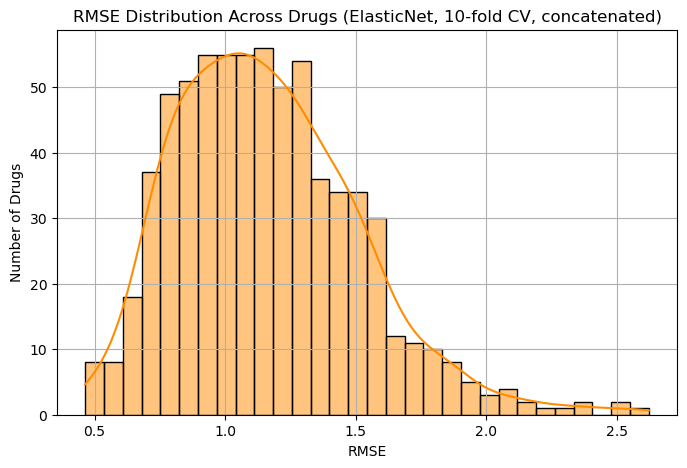

In [5]:
# Visualization: RMSE
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse"], kde=True, bins=30, color="darkorange")
plt.title(f"RMSE Distribution Across Drugs (ElasticNet, 10-fold CV, concatenated)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

## 3. R¬≤ Distribution

This distribution shows how well Elastic Net explains the variance in IC50 values.

- **R¬≤ > 0** means the model is better than the mean predictor
- **R¬≤ = 1** would be a perfect model
- Drugs with **R¬≤ close to or < 0** may not be predictable using current features


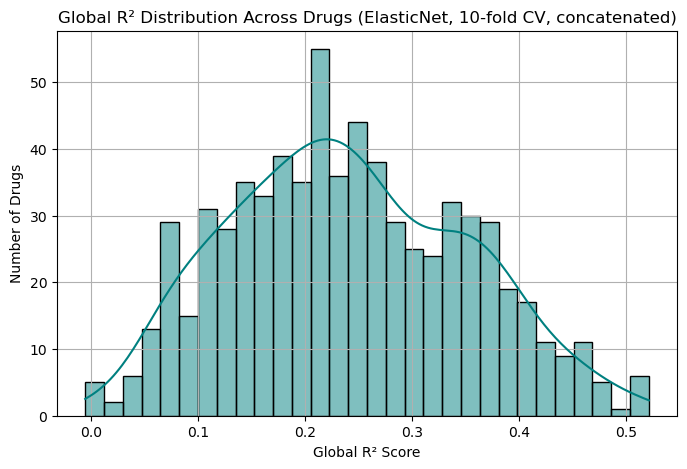

In [6]:
# Visualization: R¬≤
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_global"], kde=True, bins=30, color="teal")
plt.title(f"Global R¬≤ Distribution Across Drugs (ElasticNet, 10-fold CV, concatenated)")
plt.xlabel("Global R¬≤ Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

## 4. Summary

Elastic Net gives a more flexible alternative to linear regression models by combining L1 and L2 penalties.

From the plots above, we can see:
- The **average RMSE** and its spread across drugs
- The **R¬≤ values**, showing how well the model captures IC50 variance

This gives us a strong baseline for comparison with more complex models like XGBoost or neural networks.


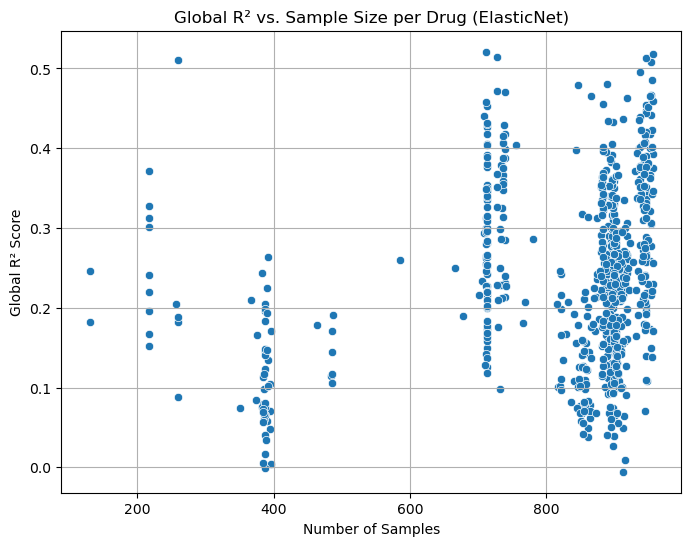

In [7]:
# Visualization: R¬≤ vs. n_samples
plt.figure(figsize=(8, 6))
sns.scatterplot(x="n_samples", y="r2_global", data=results_df)
plt.title("Global R¬≤ vs. Sample Size per Drug (ElasticNet)")
plt.xlabel("Number of Samples")
plt.ylabel("Global R¬≤ Score")
plt.grid(True)
plt.show()
plt.close()

In [8]:
# Correlations with sample size
pearson_corr, pval_pearson = pearsonr(results_df["n_samples"], results_df["r2_global"])
print(f"üìä Pearson r (samples vs R¬≤) = {pearson_corr:.3f} (p = {pval_pearson:.3g})")

spearman_corr, pval_spearman = spearmanr(results_df["n_samples"], results_df["r2_global"])
print(f"üìä Spearman œÅ (samples vs R¬≤) = {spearman_corr:.3f} (p = {pval_spearman:.3g})")

üìä Pearson r (samples vs R¬≤) = 0.207 (p = 3.96e-08)
üìä Spearman œÅ (samples vs R¬≤) = 0.224 (p = 2.43e-09)


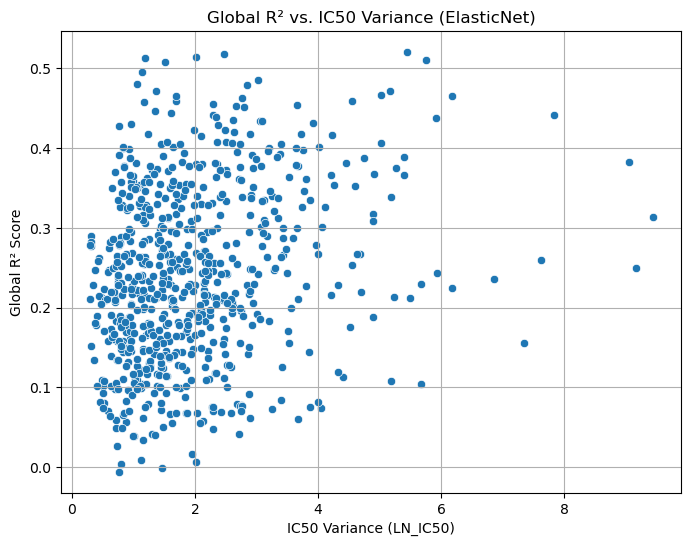

In [9]:
# R¬≤ vs. IC50 Variance
variances = data.groupby("DRUG_ID")["LN_IC50"].var()
results_df = results_df.merge(variances.rename("ic50_variance"), on="DRUG_ID")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="ic50_variance", y="r2_global")
plt.title("Global R¬≤ vs. IC50 Variance (ElasticNet)")
plt.xlabel("IC50 Variance (LN_IC50)")
plt.ylabel("Global R¬≤ Score")
plt.grid(True)
plt.show()
plt.close()

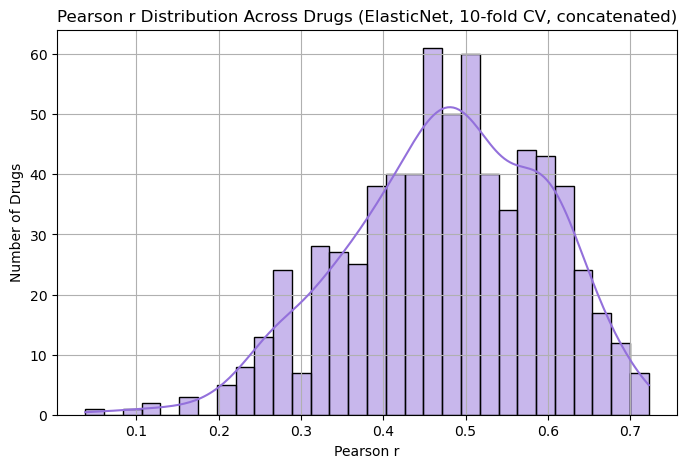

In [10]:
# üìä Pearson r Distribution Across Drugs
plt.figure(figsize=(8, 5))
sns.histplot(results_df["pearson_r"], kde=True, bins=30, color="mediumpurple")
plt.title(f"Pearson r Distribution Across Drugs (ElasticNet, 10-fold CV, concatenated)")
plt.xlabel("Pearson r")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

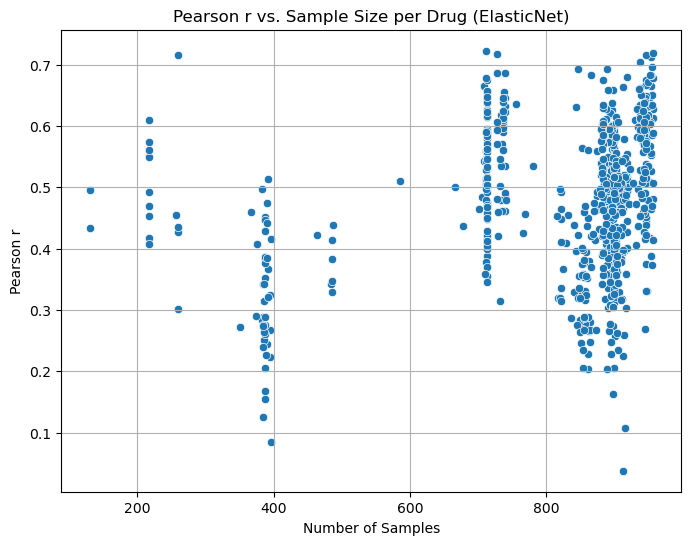

In [11]:
# üìä Pearson r vs. Number of Samples per Drug
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="n_samples", y="pearson_r")
plt.title("Pearson r vs. Sample Size per Drug (ElasticNet)")
plt.xlabel("Number of Samples")
plt.ylabel("Pearson r")
plt.grid(True)
plt.show()
plt.close()

In [12]:
pearson_corr_r, pval_pearson_r = pearsonr(results_df["n_samples"], results_df["pearson_r"])
print(f"üìä Pearson r (samples vs Pearson r) = {pearson_corr_r:.3f} (p = {pval_pearson_r:.3g})")

spearman_corr_r, pval_spearman_r = spearmanr(results_df["n_samples"], results_df["pearson_r"])
print(f"üìä Spearman œÅ (samples vs Pearson r) = {spearman_corr_r:.3f} (p = {pval_spearman_r:.3g})")


üìä Pearson r (samples vs Pearson r) = 0.218 (p = 6.36e-09)
üìä Spearman œÅ (samples vs Pearson r) = 0.222 (p = 3.38e-09)


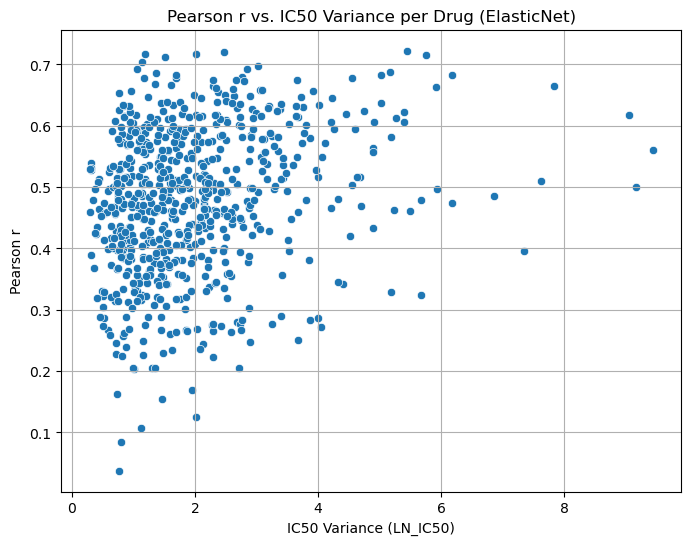

In [13]:
# üìä Pearson r vs. IC50 Variance
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="ic50_variance", y="pearson_r")
plt.title("Pearson r vs. IC50 Variance per Drug (ElasticNet)")
plt.xlabel("IC50 Variance (LN_IC50)")
plt.ylabel("Pearson r")
plt.grid(True)
plt.show()
plt.close()

In [14]:
# üìä Compute correlations for interpretation
pearson_corr_var, pval_pearson_var = pearsonr(results_df["ic50_variance"], results_df["pearson_r"])
print(f"üìä Pearson r (IC50 variance vs Pearson r) = {pearson_corr_var:.3f} (p = {pval_pearson_var:.3g})")

spearman_corr_var, pval_spearman_var = spearmanr(results_df["ic50_variance"], results_df["pearson_r"])
print(f"üìä Spearman œÅ (IC50 variance vs Pearson r) = {spearman_corr_var:.3f} (p = {pval_spearman_var:.3g})")


üìä Pearson r (IC50 variance vs Pearson r) = 0.240 (p = 1.55e-10)
üìä Spearman œÅ (IC50 variance vs Pearson r) = 0.247 (p = 4.4e-11)
